In [ ]:
# --------------------------------------------------------------
#   Anomaly Detection with SMOTE & Gaussian Mixture Models
#   ------------------------------------------------------------
#   Author:  (you)    |   Date: 2026‑01‑07
#   Dependencies:
#       - numpy, pandas, matplotlib, seaborn
#       - scikit-learn
#       - imbalanced-learn  (for SMOTE)
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    auc,
)
from sklearn.mixture import GaussianMixture

from imblearn.over_sampling import SMOTE

# --------------------------------------------------------------
# 0️⃣ Helper functions for pretty plots
# --------------------------------------------------------------
def set_style():
    sns.set(style="whitegrid", font_scale=1.2)
    plt.rcParams["figure.figsize"] = (8, 5)
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12

def plot_confusion(cm, labels=("Normal", "Fraud")):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    plt.show()

# --------------------------------------------------------------
# 1️⃣  Synthetic example to show SMOTE in action (2‑D)
# --------------------------------------------------------------
def demo_smote_2d(random_state=42):
    """
    Create a simple 2‑D binary classification problem with heavy imbalance,
    plot the original data, apply SMOTE and plot the balanced data.
    """
    X, y = make_classification(
        n_samples=500,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.95, 0.05],
        class_sep=1.0,
        random_state=random_state,
    )
    # Original scatter
    fig, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", alpha=0.6, edgecolor='k')
    ax.set_title("Original Imbalanced Data (95% Normal, 5% Fraud)")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    legend1 = ax.legend(*scatter.legend_elements(),
                        title="Class", loc="upper right")
    ax.add_artist(legend1)
    plt.show()

    # Apply SMOTE *only on the minority class* (same as on training data)
    sm = SMOTE(sampling_strategy='auto', random_state=random_state)
    X_res, y_res = sm.fit_resample(X, y)

    # Smote scatter
    fig, ax = plt.subplots()
    scatter = ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, cmap="coolwarm", alpha=0.6, edgecolor='k')
    ax.set_title("After SMOTE – Balanced (50/50) Synthetic Data")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    legend1 = ax.legend(*scatter.legend_elements(),
                        title="Class", loc="upper right")
    ax.add_artist(legend1)
    plt.show()

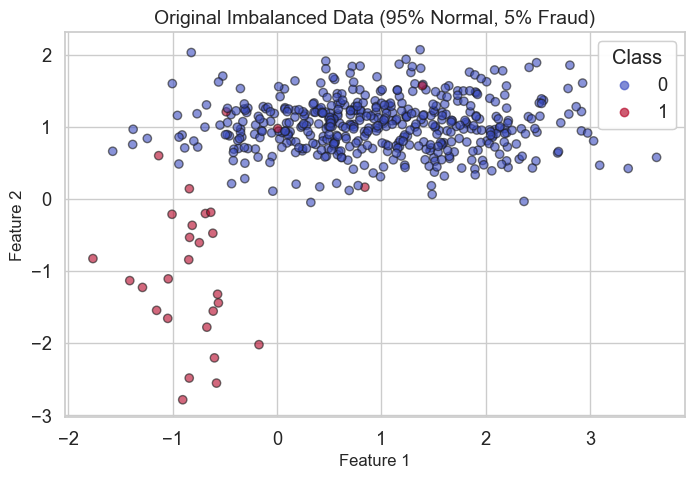

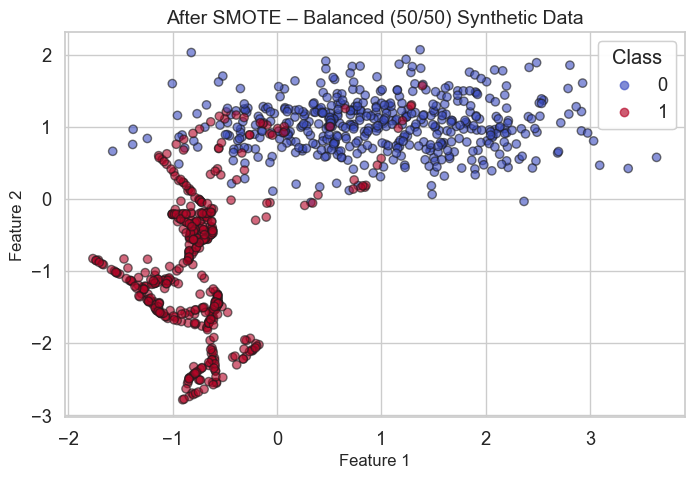

In [7]:
demo_smote_2d(40)

In [1]:
# --------------------------------------------------------------
# 2️⃣ Load the real credit‑card fraud data set and inspect feature dists
# --------------------------------------------------------------
def load_creditcard_data(csv_path="creditcard.csv"):
    """
    Load the Kaggle credit‑card‑fraud dataset.
    If you don't have the file, you can download it from:
    https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
    """
    df = pd.read_csv(csv_path)
    # The dataset already contains a `Class` column (0 = normal, 1 = fraud)
    return df

def plot_feature_distributions(df, features=None, n_rows=4, n_cols=4):
    """
    Plot KDE distributions for a set of features,
    overlaying Normal (Class=0) and Fraud (Class=1) curves.
    """
    set_style()
    if features is None:
        # Show the first N anonymised V columns + Amount
        features = [c for c in df.columns if c.startswith('V')] + ['Amount']
    n = len(features)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axes = axes.ravel()
    for i, col in enumerate(features[: n_rows * n_cols]):
        sns.kdeplot(
            data=df,
            x=col,
            hue="Class",
            fill=True,
            common_norm=False,
            palette={0: "steelblue", 1: "tomato"},
            alpha=0.5,
            ax=axes[i],
        )
        axes[i].set_title(f"Distribution of {col}")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# 3️⃣ Fit a Gaussian Mixture Model on *only* the normal class
# --------------------------------------------------------------
def train_gmm_on_normals(df, n_components=3, cov_type="diag", random_state=42):
    """
    Train a GMM using only the rows where Class == 0.
    Returns the trained model and the feature matrix used.
    """
    # Keep only the original V‑features + Amount (drop Time for simplicity)
    feature_cols = [c for c in df.columns if c.startswith('V')] + ['Amount']
    X = df.loc[df["Class"] == 0, feature_cols].values

    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=cov_type,
        random_state=random_state,
        reg_covar=1e-6,   # small regularisation for numerical stability
    )
    gmm.fit(X)
    return gmm, feature_cols

def compute_anomaly_scores(gmm, X):
    """
    Return negative log‑likelihood (the lower, the more normal).
    """
    # gmm.score_samples returns per‑sample average log-likelihood.
    # Use negative to have larger values = more anomalous.
    return -gmm.score_samples(X)

def plot_gmm_contours(gmm, X, y=None, feature_x=0, feature_y=1):
    """
    Visualise a 2‑D slice of the GMM as contour lines.
    Only works sensibly if `X` has at least 2 features.
    """
    set_style()
    # Create a meshgrid over the feature range
    x_min, x_max = X[:, feature_x].min() - 1, X[:, feature_x].max() + 1
    y_min, y_max = X[:, feature_y].min() - 1, X[:, feature_y].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    # Build a full feature matrix for the grid (fill other dimensions with 0)
    grid = np.zeros((xx.size, X.shape[1]))
    grid[:, feature_x] = xx.ravel()
    grid[:, feature_y] = yy.ravel()
    Z = -gmm.score_samples(grid).reshape(xx.shape)  # negative log-likelihood

    # Plot contours
    fig, ax = plt.subplots()
    cs = ax.contourf(xx, yy, Z, levels=30, cmap="viridis")
    fig.colorbar(cs, ax=ax, label="Anomaly score (−log‑likelihood)")

    # Scatter the true points (if label information given)
    if y is not None:
        palette = {0: "steelblue", 1: "tomato"}
        sns.scatterplot(
            x=X[:, feature_x],
            y=X[:, feature_y],
            hue=y,
            palette=palette,
            edgecolor="k",
            alpha=0.6,
            ax=ax,
        )
    else:
        ax.scatter(X[:, feature_x], X[:, feature_y], c="grey", alpha=0.5, s=10)

    ax.set_xlabel(f"Feature {feature_x}")
    ax.set_ylabel(f"Feature {feature_y}")
    ax.set_title("GMM Density Contours (2‑D slice)")
    plt.show()

# --------------------------------------------------------------
# 4️⃣ Threshold sweep → precision‑recall curve & custom ratio
# --------------------------------------------------------------
def evaluate_gmm_thresholds(
    gmm,
    X_test,
    y_test,
    thresholds=np.linspace(0, 20, 200),
):
    """
    Compute precision, recall, F1 and the custom ratio TP/(TP+FP) for a
    range of anomaly‑score thresholds.
    Returns a DataFrame for easy plotting.
    """
    scores = compute_anomaly_scores(gmm, X_test)
    results = {"threshold": [], "precision": [], "recall": [], "f1": [], "ratio": []}
    for th in thresholds:
        y_pred = (scores > th).astype(int)  # 1 = predicted fraud (anomaly)
        tp = ((y_test == 1) & (y_pred == 1)).sum()
        fp = ((y_test == 0) & (y_pred == 1)).sum()
        fn = ((y_test == 1) & (y_pred == 0)).sum()
        tn = ((y_test == 0) & (y_pred == 0)).sum()
        # Guard against division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (
            2 * precision * recall / (precision + recall)
            if (precision + recall) > 0
            else 0.0
        )
        ratio = precision  # same as TP/(TP+FP)
        results["threshold"].append(th)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1"].append(f1)
        results["ratio"].append(ratio)
    return pd.DataFrame(results)

def plot_precision_recall_curve(df_thresh):
    """
    Plot precision‑recall trade‑off and also show the custom ratio.
    """
    set_style()
    fig, ax1 = plt.subplots()
    ax1.plot(df_thresh["recall"], df_thresh["precision"], label="Precision‑Recall", color="tab:blue")
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_title("Precision‑Recall Curve & Ratio vs Threshold")
    # Secondary axis for the ratio (which is the same as precision)
    ax2 = ax1.twinx()
    ax2.plot(df_thresh["threshold"], df_thresh["ratio"], label="Ratio (TP/(TP+FP))", color="tab:red", alpha=0.6)
    ax2.set_ylabel("Ratio (same as Precision)", color="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    fig.tight_layout()
    plt.show()

# --------------------------------------------------------------
# 5️⃣ Full pipeline (put it all together)
# --------------------------------------------------------------
def full_demo(csv_path="creditcard.csv", random_state=42):
    """
    End‑to‑end demo:
    1️⃣ Load data
    2️⃣ Visualise a few feature distributions
    3️⃣ Train‑test split (stratified)
    4️⃣ Train GMM on normal training data
    5️⃣ Sweep thresholds → PR curve + ratio
    6️⃣ Show final confusion matrix for a chosen threshold
    """
    # ---------- 1️⃣ Load ----------
    df = load_creditcard_data(csv_path)

    # ---------- 2️⃣ Feature visualisation ----------
    print("\n🔎 Plotting feature distributions (first 16 features)...")
    plot_feature_distributions(df, n_rows=4, n_cols=4)

    # ---------- 3️⃣ Train‑test split ----------
    X = df.drop(columns=["Class", "Time"])  # drop "Time" – usually not needed
    y = df["Class"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # ---------- 4️⃣ GMM training on normal class ----------
    # Keep only normal rows from the training set
    normal_train = X_train[y_train == 0]
    # Convert to numpy – GMM expects float64
    normal_train_np = normal_train.values
    gmm = GaussianMixture(
        n_components=4,
        covariance_type="diag",
        random_state=random_state,
        reg_covar=1e-6,
    )
    gmm.fit(normal_train_np)

    # ---------- 5️⃣ Threshold sweep ----------
    # Compute scores on the *full* test set (including frauds)
    X_test_np = X_test.values
    df_thresh = evaluate_gmm_thresholds(gmm, X_test_np, y_test.values)

    print("\n📈 Plotting Precision‑Recall curve and ratio vs. threshold...")
    plot_precision_recall_curve(df_thresh)

    # Pick a threshold that gives a good trade‑off (e.g. the one with max F1)
    idx_best_f1 = df_thresh["f1"].idxmax()
    best_thr = df_thresh.loc[idx_best_f1, "threshold"]
    best_prec = df_thresh.loc[idx_best_f1, "precision"]
    best_rec = df_thresh.loc[idx_best_f1, "recall"]
    best_f1 = df_thresh.loc[idx_best_f1, "f1"]
    print(
        f"\n✅ Best threshold (max F1={best_f1:.3f}) → {best_thr:.3f}\n"
        f"   Precision = {best_prec:.3f}, Recall = {best_rec:.3f}"
    )

    # ---------- 6️⃣ Confusion matrix for chosen threshold ----------
    test_scores = compute_anomaly_scores(gmm, X_test_np)
    y_pred = (test_scores > best_thr).astype(int)  # 1 = anomaly → predicted fraud
    cm = confusion_matrix(y_test, y_pred)
    print("\n🔢 Confusion matrix at best threshold:")
    print(cm)
    plot_confusion(cm, labels=("Normal", "Fraud"))

    # ----------------------------------------------------------
    # OPTIONAL: Show a 2‑D contour (e.g. using V1 vs V2)
    # ----------------------------------------------------------
    # For visual sake we use only the first two features.
    # Comment out if you don't have a nice 2‑D view.
    print("\n👁️ Plotting GMM density contours on V1 vs V2 (2‑D slice)...")
    feature_cols = X.columns.tolist()
    # Train a new GMM on only V1 and V2 for a cleaner contour (optional)
    gmm_2d = GaussianMixture(
        n_components=4, covariance_type="full", random_state=random_state
    )
    gmm_2d.fit(normal_train[[feature_cols[0], feature_cols[1]]].values)
    plot_gmm_contours(
        gmm_2d,
        X_test[[feature_cols[0], feature_cols[1]]].values,
        y_test.values,
        feature_x=0,
        feature_y=1,
    )

# --------------------------------------------------------------
# Run the demo (uncomment the line below if you have creditcard.csv)
# --------------------------------------------------------------
# full_demo(csv_path="creditcard.csv")


🔎 Plotting feature distributions (first 16 features)...


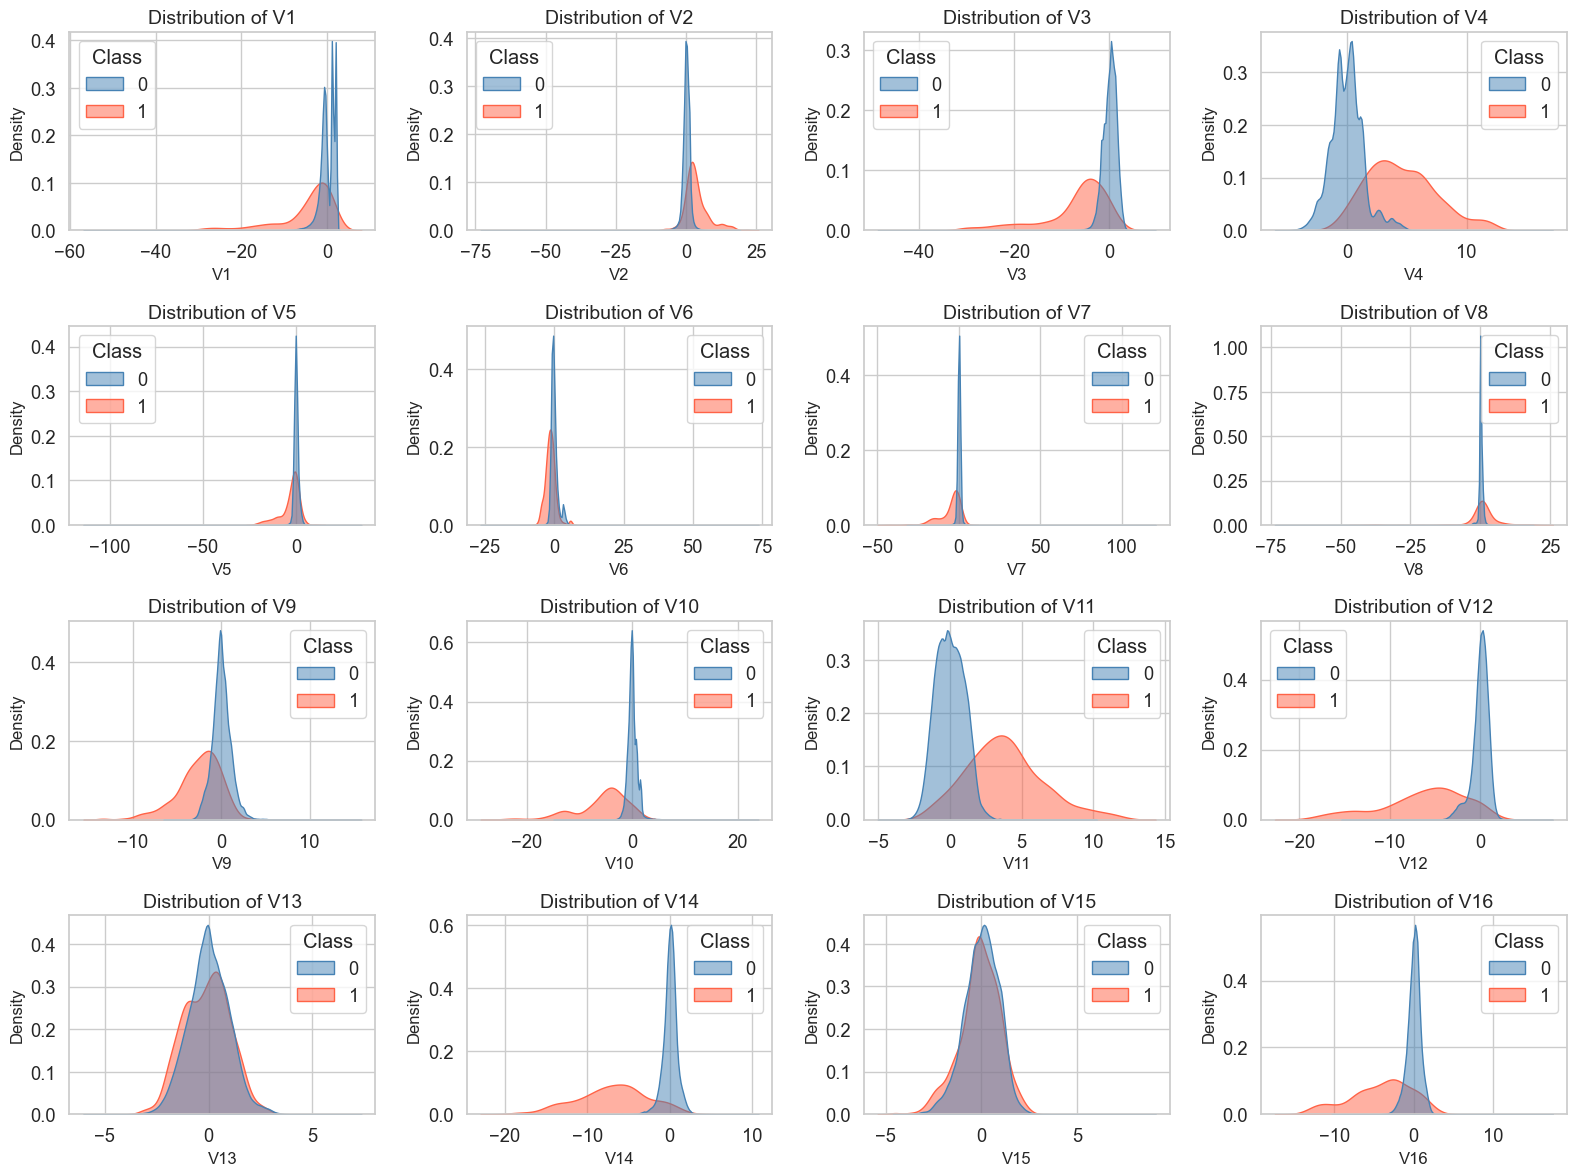


📈 Plotting Precision‑Recall curve and ratio vs. threshold...


/var/folders/_z/fcth_nbd7hg70v8d_k1tt9sr0000gn/T/ipykernel_85082/1697586773.py:260: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.tight_layout()
/Users/pewhite/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


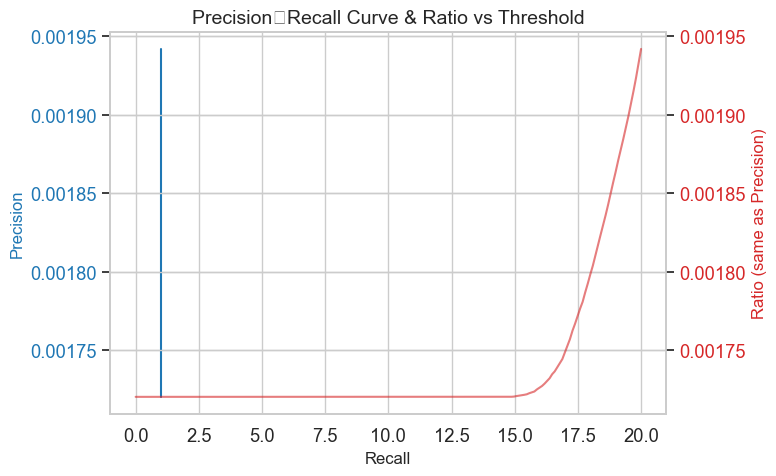


✅ Best threshold (max F1=0.004) → 20.000
   Precision = 0.002, Recall = 1.000

🔢 Confusion matrix at best threshold:
[[ 6500 50364]
 [    0    98]]


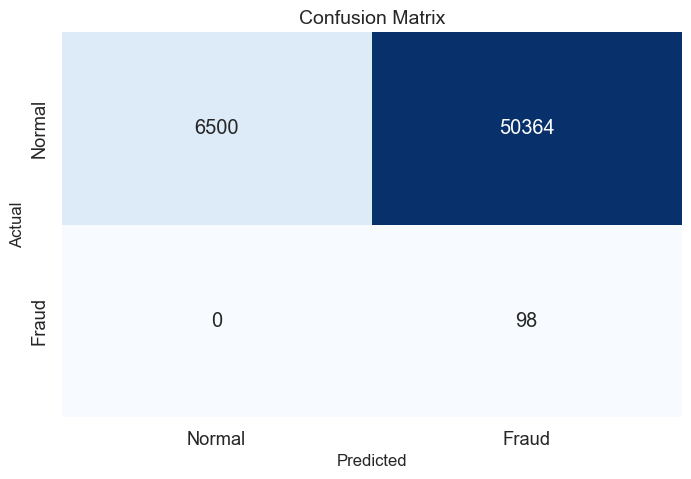


👁️ Plotting GMM density contours on V1 vs V2 (2‑D slice)...


/Users/pewhite/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


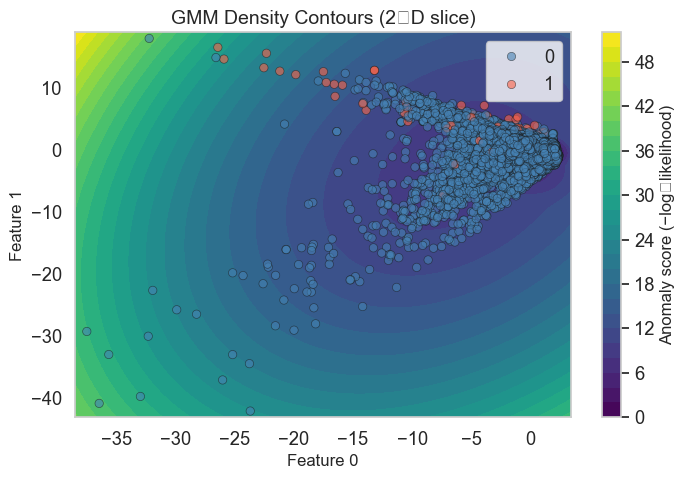

In [4]:
import kagglehub
import tqdm as notebook_tqdm
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
full_demo(csv_path=path + "/creditcard.csv")
